# Практическая работа 1. Работу выполнил: Моложавенко Александр Александрович
## Импортирование библиотек

In [1]:
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

## а) Фотокарточки

In [3]:
pic_paths = ["pic/" + str(i + 1) + ".jpg" for i in range(5)]
back_path = "pic/back.jpg"

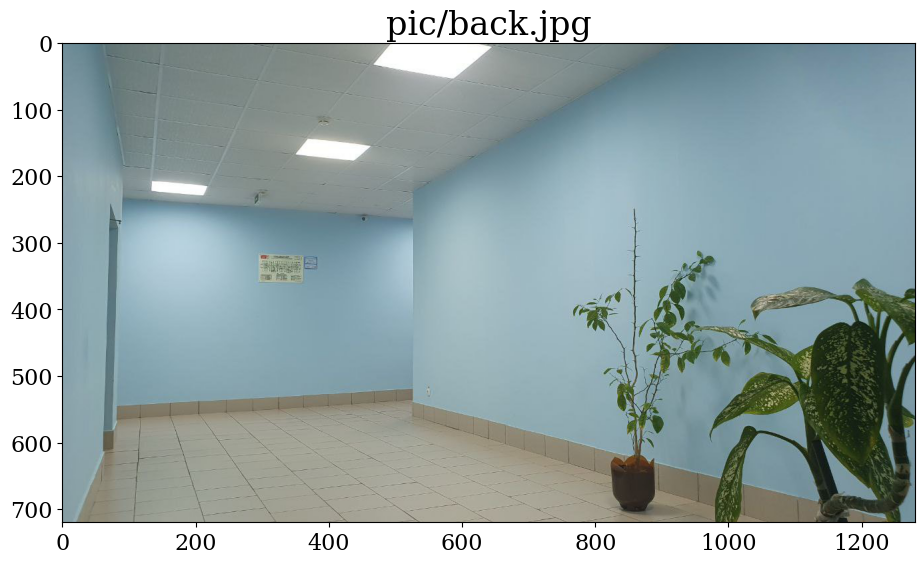

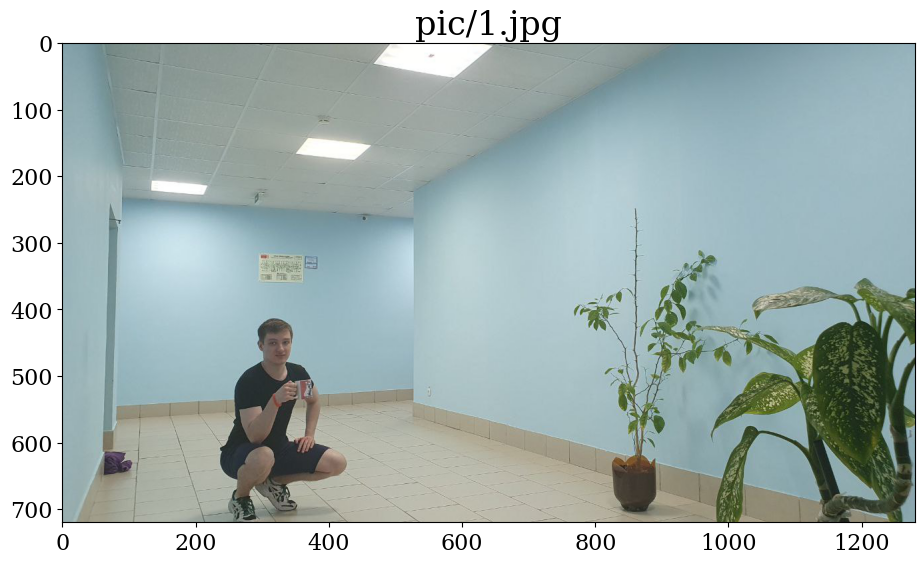

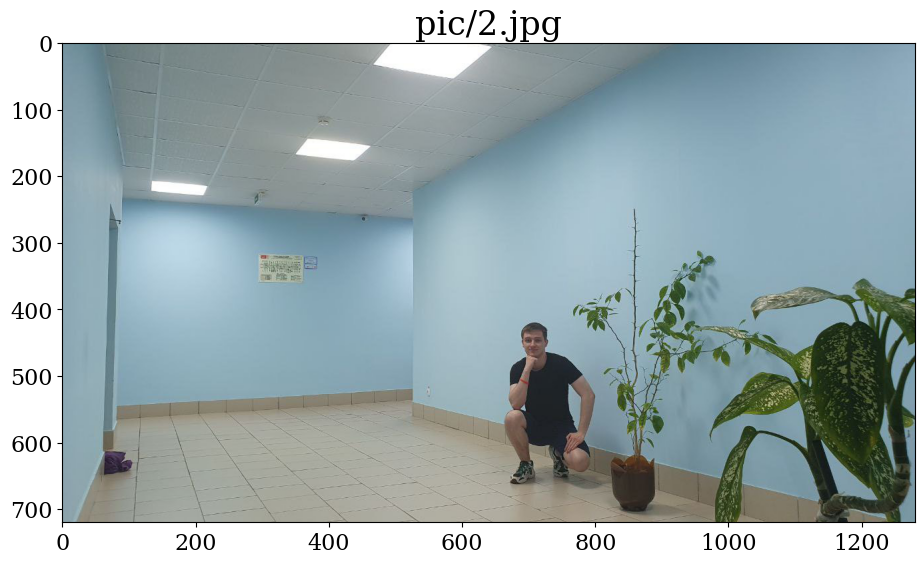

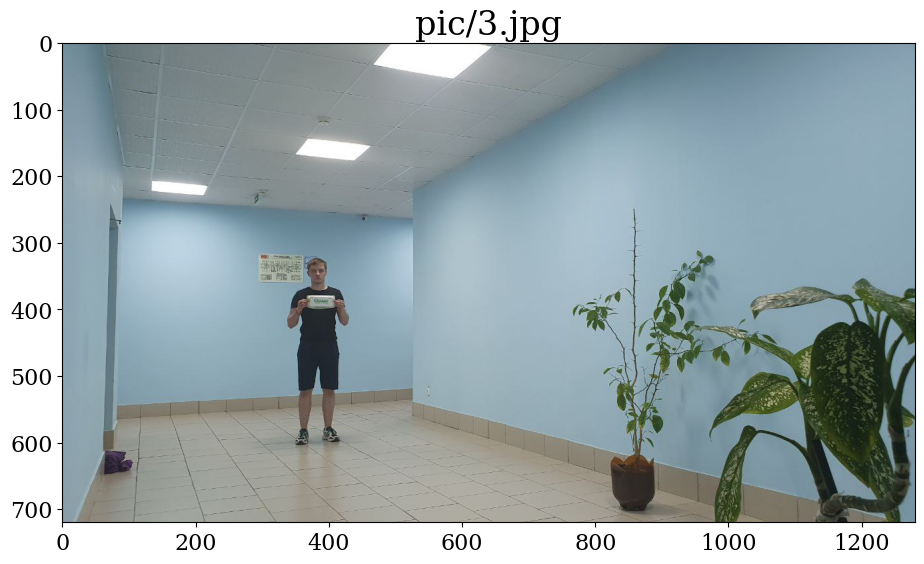

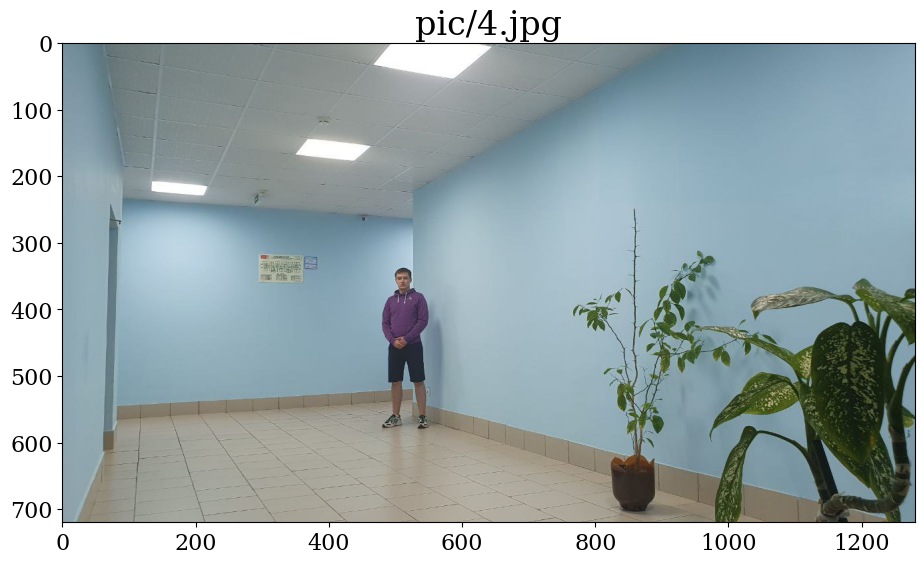

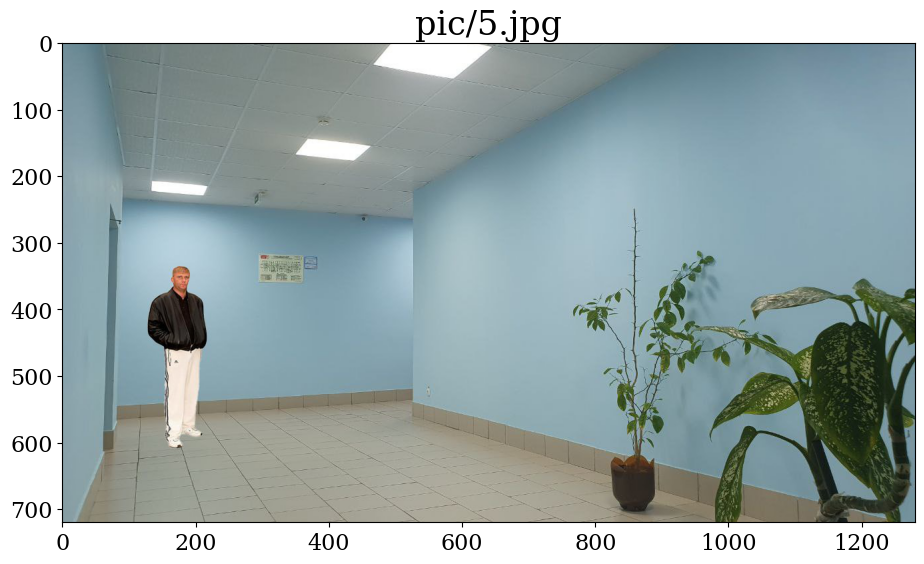

In [4]:
plt.imshow(plt.imread(back_path))
plt.title(back_path)
plt.show()

for pic_path in pic_paths:
    plt.imshow(plt.imread(pic_path))
    plt.title(pic_path)
    plt.show()

## б) Коллаж из $K = 2$ изображений

$$
E(\mathbf{x}) = \theta_0 + \sum_i \theta_i(x_i) + \sum_{(i, j)\in \varepsilon} \theta_{ij}(x_i, x_j)
$$

- **Система соседства**:
  для картинки с коодинатами $(k, l)$: соседи $\{(k - 1, l - 1), (k - 1, l), (k - 1, l + 1), (k, l - 1), (k, l + 1), (k + 1, l - 1), (k + 1, l), (k + 1, l + 1)\}$, если каких-то координат не существует, то они попросту не добавляются. Иными словами у элементов с границы соседей меньше.
  
- **Вид унитарных потенциалов**:
  $\theta_i (x_i) = x_i$, то есть $\forall i \implies \theta_i(0) = 0, \theta_i(1) = 1$
  
- **Вид парных потенциалов**:
  $$
  \theta_{ij}(x_i, x_j) = [x_i \neq x_j] \cdot \exp \left(- \frac{\|y_i - y_j\|^2_2}{2\sigma^2}\right),
  $$
  
  где $x_i$ - метка того, к какому изображению принадлежит пиксель с номером $i$, а $y_i$ - вектор из трех чисел (цвета соответствующего пикселя в картинке $x_i$)
  

**Выбранные потенциалы отражают цель построить правдоподобный для человеческого глаза коллаж** следующим образом: унарные потенциалы провоцируют выбирать картинку с меткой ноль (поскольку метка второй картинки равна одному, а один, как известно, больше нуля). Выбор картинки не принципиален поскольку фон у всех одинаковый. Далее в дело включаются парные потенциалы: если сосед выбранного пикселя с той же картинки, что и он сам, то ничего не меняется. Иначе мы считаем квадрат нормы разницы RGB векторов пикселей с разных картинок. Если разница не очень большая, то ничего не меняется, а если разница огромная, то выгоднее поменять источник пикселя (то есть номер его картинки).

**Чтобы указать, что некоторые части коллажа стоит брать из определенного изображения,** унарные потенциалы в пикселях этих частей выберем так, чтобы их значение на противоположной картинке равнялось $+\infty$. То есть, если я хочу, чтобы пиксель с номером $i$ был из изображения номер ноль, то я определю $\theta_i(1) := +\infty, \theta_i(0) < +\infty$, тогда алгоритму ничего не останется, кроме того как выбрать картинку номер ноль для определения пикселя с номером $i$.


**Функция энергии $E(\mathbf{x}$) связана с вероятностью появления коллажа $p(\mathbf{x})$** следующим образом: $E(\mathbf{x}) \to \min\limits_{\mathbf{x}}$, то есть вероятность выбрать конкретную конфигурацию $\mathbf{x}$ пропорциональна вероятности оптимизационного алгоритма в качестве $\arg\min$ задачи выбрать $\mathbf{x}$:

$$
\log p(\mathbf{x}) \propto -E(\mathbf{x})
$$
